![title](../images/header.png)

# Ve - Supervised country model trained with CEO data
-------
This notebook performs a supervised classification of eSBAE points based on the validated data from systematic points for training
This script estimates several models of forest change (deforestation, degradation, stable, NF) based on the visually interpreted data and eSBAE variables. 
This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [35]:
#pip install --user git+https://github.com/BuddyVolly/sampling-handler
#!pip install xgboost

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt
import seaborn as sns

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling

from imblearn import FunctionSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

import folium
import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.10/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


## Parameters

### 1 - data preparation
#### 1.1 - Import merged esbae and CEO interpreted data
Import the merged dataset from script 5d - CEO with all eSBAE columns

In [52]:
ceo_esbae = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_esbae_w_ceo_1522.csv', delimiter=',')
ceo_esbae.head()

,geometry,point_id,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ewma_jrc_date,ewma_jrc_change,ewma_jrc_magnitude,mosum_jrc_date,mosum_jrc_change,mosum_jrc_magnitude,cusum_jrc_date,cusum_jrc_change,cusum_jrc_magnitude,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_2021,tmf_2022,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,plotid_orig,ISO,countDrivers,InfraR,Urb,ArtAg,IndAg,ArtFor,IndFor,ArtMin,IndMin,Other,sampling,Change_Bin,Stable_Bin,Def_Bin,Deg_Bin,NF_Bin,chg_prob_cafi1520,def_prob_cafi1520,deg_prob_cafi1520,stable_prob_cafi1520,kmeans_chg_1520,kmeans_def_1520,kmeans_deg_1520,lon,lat,ID,plotid,sampleid,email,flagged,collection_time,analysis_duration,sample_geom,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor.1,ArtMine,InfraR.1,Urb.1,IndFor.1,Other.1,Other_Desc,IndMine,IndAg.1,ArtAg.1,Ref_Year,Ref_NFtype,Ref_Ftype,Commentaires,collection,interpreted,Ref_LCover,Ref_Change_Year_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,Stable,NF,ISO.1
0,POINT (8.955453437092244 5.778794305718453),108803.0,81,-1.000,0.000000,0.000000,2018.093,0.172641,8738.995797,9419.804703,695.357973,6938.0,10000.0,9419.804703,695.357973,6938.0,10000.0,9419.804703,695.357973,6938.0,10000.0,9419.804703,695.357973,6938.0,10000.0,9419.804703,695.357973,6938.0,10000.0,9419.804703,695.357973,6938.0,10000.0,9419.804703,695.357973,6938.0,10000.0,9419.804703,695.357973,6938.0,10000.0,-39.527643,24.558789,35.944983,-104.011392,17141,1,599.742927,0,0,-0.310863,17525,1,2.257621,0.000,0.000000,0.0,1.0,74.0,11.0,12.0,66.0,0.0,10,10,2,2,2,2.0,2,0,0,0.0,76,36.0,30,0.0,1,1,1,1,1,1.0,1.0,0.0,0.0,10.0,10.0,NaN,CMR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,systematic,NaN,NaN,NaN,NaN,NaN,0.154000,0.046000,0.148000,0.690667,1,1,2,8.955453,5.778794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,CMR
1,POINT (8.945416000620938 5.778825519425826),108777.0,78,2022.408,331.198334,0.416161,2021.005,0.059641,4545.900794,9772.324603,421.526188,7763.0,10000.0,9772.324603,421.526188,7763.0,10000.0,9772.324603,421.526188,7763.0,10000.0,9772.324603,421.526188,7763.0,10000.0,9772.324603,421.526188,7763.0,10000.0,9772.324603,421.526188,7763.0,10000.0,9772.324603,421.526188,7763.0,10000.0,9772.324603,421.526188,7763.0,10000.0,16.450595,13.408200,51.301175,-24.543828,17397,1,391.775218,18501,1,2.143120,18253,1,4.314672,0.000,0.000000,0.0,1.0,75.0,7.0,14.0,65.0,0.0,10,10,2,2,2,2.0,2,0,0,0.0,76,36.0,26,0.0,1,1,1,1,1,1.0,1.0,0.0,0.0,10.0,10.0,NaN,CMR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,systematic,NaN,NaN,NaN,NaN,NaN,0.080000,0.065333,0.059333,0.708667,1,1,1,8.945416,5.778826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,CMR
2,POINT (8.960532353192116 5.769184942948277),108830.0,94,2018.488,69.309608,-0.394872,2022.847,0.390479,11710.868338,9612.864792,651.250321,6215.0,10000.0,9612.864792,651.250321,6215.0,10000.0,9612.864792,651.250321,6215.0,10000.0,9612.864792,651.250321,6215.0,10000.0,9612.864792,651.250321,6215.0,10000.0,9612

In [53]:
#what is the time period of the CEO data
time_period = '15_22'

In [54]:
# output file of eSBAE points with new model classification
out_file =  '/home/sepal-user/module_results/esbae/CAR/CAR_esbae_1522_model.csv'

### Augmented dataset for country of interest
#### this is the output folder from eSBAE script 4 which is the new augmented data you want to classify

In [ ]:
files = Path('/home/sepal-user/module_results/esbae/CAR/04_Dataset_Augmentation/Landsat/').glob('*geojson')

### End of parameters

In [55]:
len(ceo_esbae)

394066

In [56]:
ceo_esbae['kmeans_chg_1520'].value_counts(dropna=False)

kmeans_chg_1520
2    209904
1    152770
3     31392
Name: count, dtype: int64

In [58]:
pd.pivot_table(ceo_esbae,values='point_id',index=['Ref_Change_Type_1522'],columns=['kmeans_chg_1520'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg_1520,1,2,3,Total
Ref_Change_Type_1522,,,,
Def,6,59,72,137
Deg,9,58,63,130
NF,21,3219,645,3885
Stable,386,1374,821,2581
Total,422,4710,1601,6733


In [59]:
pd.pivot_table(ceo_esbae,values='point_id',index=['Ref_Change_Year_1522'],columns=['kmeans_chg_1522'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg_1520,1,2,3,Total
Ref_Change_Year_1522,,,,
Def2016,NaN,8.0,8.0,16
Def2017,1.0,17.0,12.0,30
Def2018,1.0,9.0,11.0,21
Def2019,NaN,8.0,10.0,18
Def2020,2.0,7.0,10.0,19
Def2021,1.0,5.0,14.0,20
Def2022,1.0,5.0,7.0,13
Deg2016,NaN,10.0,8.0,18
Deg2017,1.0,9.0,5.0,15


In [60]:
all_ceo_cols = ceo_esbae.columns.tolist()

# Display the list of column names
print(all_ceo_cols)

['geometry', 'point_id', 'mon_images', 'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation

In [61]:
#training columns
eSBAE_cols = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    #'images', 'mon_images',
    #'bfast_change_date', 'bfast_magnitude', 'bfast_means', 
    'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 
    'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 
    'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 
    'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 
    'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
    'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 
    'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 
    'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 
    'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 
    'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 
    'ccdc_change_date', 'ccdc_magnitude', 'aspect', 
    'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 
    'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 
    #'gfc_gain', 
    'gfc_loss', 'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'potapov_tree_height', 'slope', 
    'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub']

In [62]:
df = ceo_esbae

### 1.2 where/what are NAs
evaluate and replace no data values

In [63]:
# Initialize a dictionary to store the counts by column
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'aspect': 0, 'dw_class_mode': 0, 'dw_tree_prob__max': 0, 'dw_tree_p

In [64]:
# Specify the columns to replace NaN with 0 (categorical data)
columns_to_fill = ['gfc_lossyear', 'gfc_gain','gfc_loss', 'lang_tree_height', 'esa_lc20', 'esa_lc21', 'esri_lc20',  'esri_lc21' , 'esri_lc19', 'esri_lc18', 'esri_lc17', 
                   'potapov_tree_height','elevation','slope', 'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'aspect']

# Set NaN values in the selected columns to 0
df[columns_to_fill] = df[columns_to_fill].fillna(0)

In [65]:
# Specify the columns you want to impute with the mean value - continuous data
columns_to_impute = ['dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__stdDev','dw_tree_prob_mean', 'dw_tree_prob__min']

# Impute NaN values in the selected columns with the mean
for column in columns_to_impute:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [66]:
#check for remaining missing counts - when there are only 0's you may proceed to next step
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'aspect': 0, 'dw_class_mode': 0, 'dw_tree_prob__max': 0, 'dw_tree_p

In [67]:
df['Stable'].value_counts(dropna=False)

Stable
NaN    387333
0.0      4152
1.0      2581
Name: count, dtype: int64

In [68]:
#convert to geo data frame for mapping
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))

In [69]:
interpreted = gdf[gdf['interpreted'] == 1]

### 1.3 Run classifications on entire eSBAE dataset trained with CEO interpreted data

#### 4 individual models
we create binary models for deforestation, degradation, stable and non-forest based on visually interpreted data from CEO

In [71]:
# predictors used change/nochange classification
gdf['def_prob_1522'] = clf.binary_probability_classification(gdf, 'Defall', eSBAE_cols, outlier=False)

OOB Score is 0.726273577899896


array([<Axes: title={'center': 'def_prob_1522'}>], dtype=object)

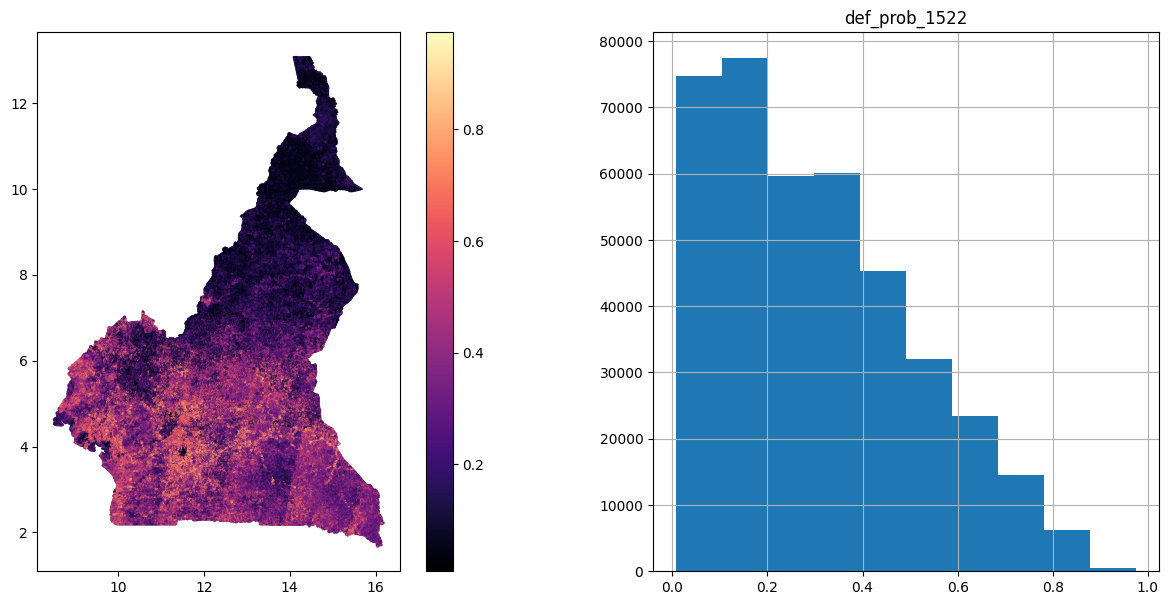

In [72]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('def_prob_1522', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('def_prob_1522', ax=ax[1])

In [73]:
# predictors used change/nochange classification
gdf['deg_prob_1522'] = clf.binary_probability_classification(gdf, 'Degall', eSBAE_cols, outlier=False)

OOB Score is 0.6886974602703104


array([<Axes: title={'center': 'deg_prob_1522'}>], dtype=object)

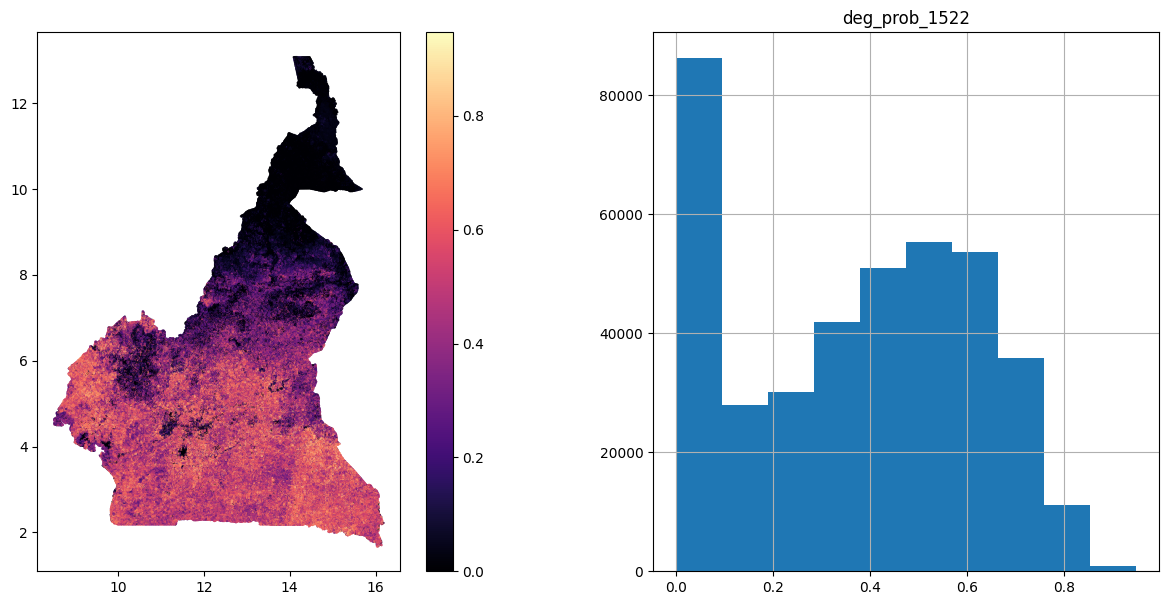

In [74]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('deg_prob_1522', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('deg_prob_1522', ax=ax[1])

In [75]:
# predictors used change/nochange classification
gdf['stable_prob_1522'] = clf.binary_probability_classification(gdf, 'Stable', eSBAE_cols, outlier=False)

OOB Score is 0.7736521609980692


array([<Axes: title={'center': 'stable_prob_1522'}>], dtype=object)

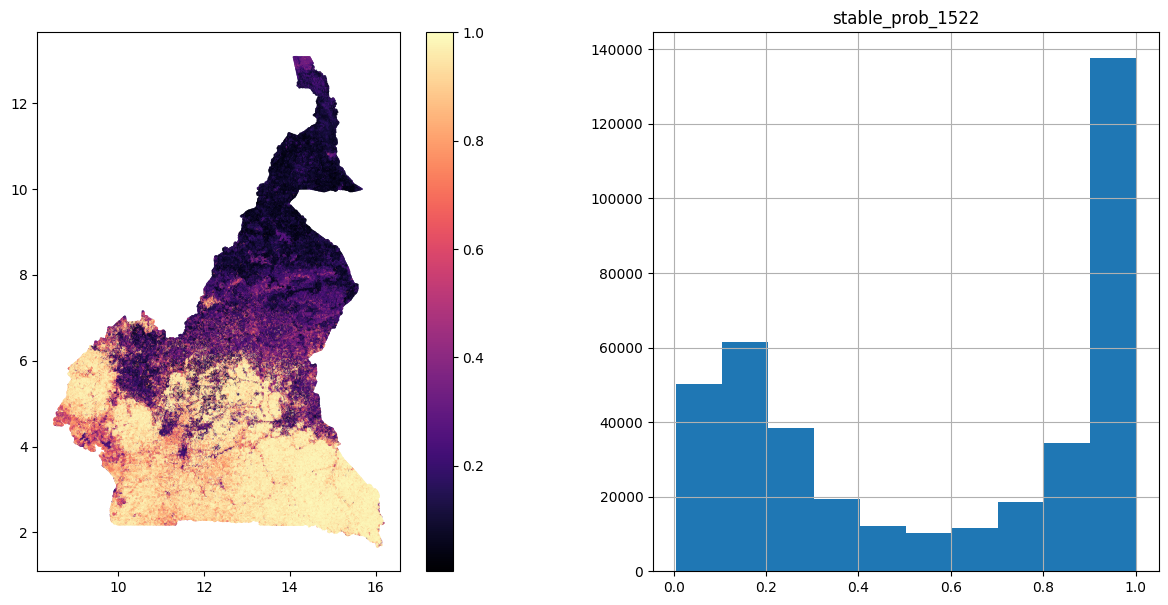

In [76]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('stable_prob_1522', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('stable_prob_1522', ax=ax[1])

In [77]:
# predictors used change/nochange classification
gdf['nf_prob_1522'] = clf.binary_probability_classification(gdf, 'NF', eSBAE_cols, outlier=False)

OOB Score is 0.7329330619743901


array([<Axes: title={'center': 'nf_prob_1522'}>], dtype=object)

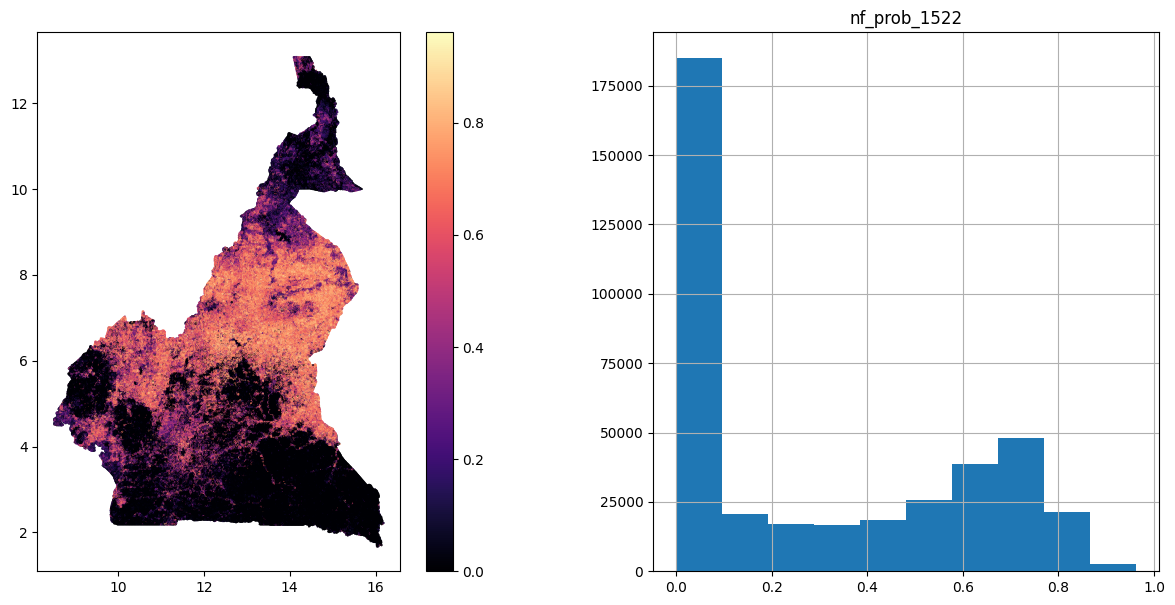

In [78]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('nf_prob_1522', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('nf_prob_1522', ax=ax[1])

In [79]:
interpreted_rows = gdf[gdf['interpreted'] == 1]

In [ ]:
####add new kmeans classifier

##### looking at validated data in comparison to model

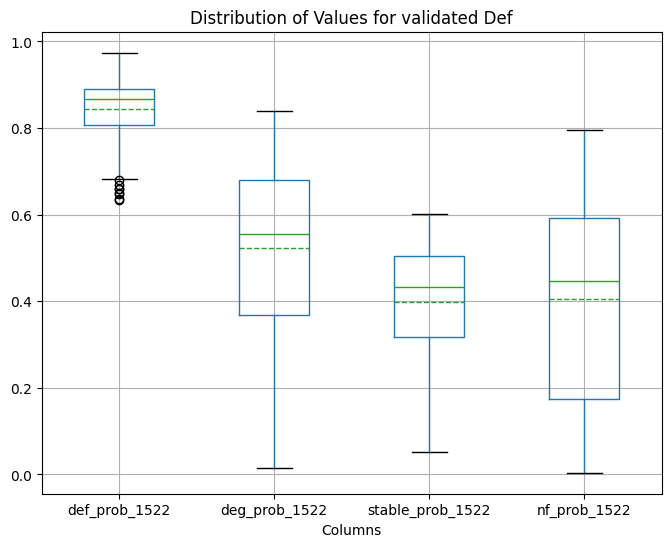

       def_prob_1522  deg_prob_1522  stable_prob_1522  nf_prob_1522
count     137.000000     137.000000        137.000000    137.000000
mean        0.843017       0.522866          0.398224      0.404063
std         0.079597       0.206628          0.138381      0.243614
min         0.634667       0.014000          0.051333      0.004000
25%         0.806667       0.368667          0.317333      0.173333
50%         0.866000       0.554000          0.432000      0.447333
75%         0.889333       0.680667          0.504000      0.592000
max         0.974000       0.839333          0.602000      0.795333


In [80]:
# Filter rows by a interpreted change category 
selected_category = 'Def'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob_1522', 'deg_prob_1522', 'stable_prob_1522', 'nf_prob_1522']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob_1522', 'deg_prob_1522', 'stable_prob_1522', 'nf_prob_1522'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

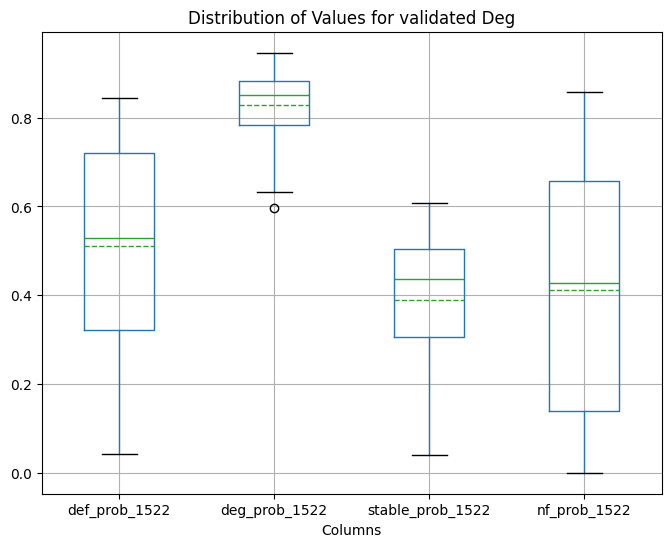

       def_prob_1522  deg_prob_1522  stable_prob_1522  nf_prob_1522
count     130.000000     130.000000        130.000000    130.000000
mean        0.511713       0.828938          0.389405      0.410528
std         0.223294       0.071843          0.152910      0.270390
min         0.042000       0.596000          0.039333      0.000000
25%         0.322333       0.782333          0.305833      0.139167
50%         0.528000       0.851667          0.436333      0.428333
75%         0.719667       0.883000          0.503833      0.656167
max         0.843333       0.946667          0.608667      0.858667


In [81]:
# Filter rows by a interpreted change category 
selected_category = 'Deg'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob_1522', 'deg_prob_1522', 'stable_prob_1522', 'nf_prob_1522']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob_1522', 'deg_prob_1522', 'stable_prob_1522', 'nf_prob_1522'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

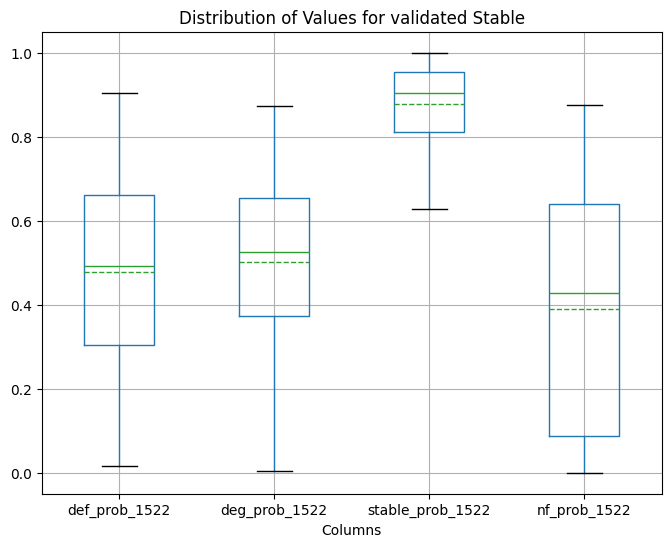

       def_prob_1522  deg_prob_1522  stable_prob_1522  nf_prob_1522
count    2581.000000    2581.000000       2581.000000   2581.000000
mean        0.477053       0.502027          0.877358      0.389538
std         0.219731       0.196324          0.093366      0.275620
min         0.016000       0.003333          0.626667      0.000000
25%         0.303333       0.372000          0.811333      0.088000
50%         0.492667       0.525333          0.904000      0.427333
75%         0.660667       0.653333          0.954667      0.640000
max         0.904667       0.874000          1.000000      0.874667


In [82]:
# Filter rows by a interpreted change category 
selected_category = 'Stable'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob_1522', 'deg_prob_1522', 'stable_prob_1522', 'nf_prob_1522']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob_1522', 'deg_prob_1522', 'stable_prob_1522', 'nf_prob_1522'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

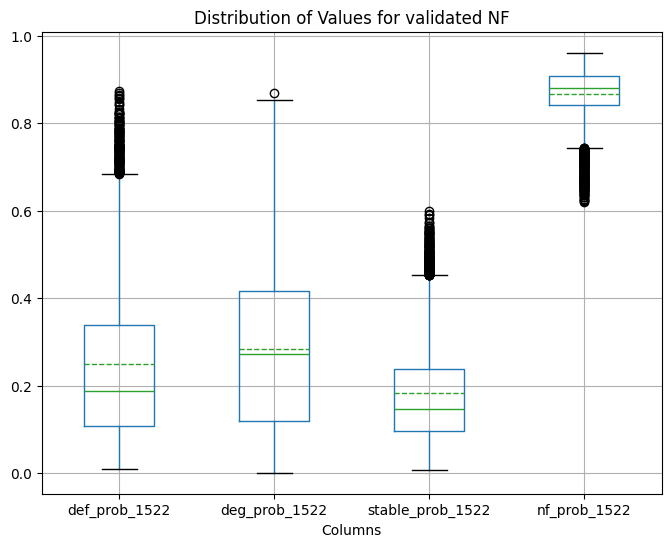

       def_prob_1522  deg_prob_1522  stable_prob_1522  nf_prob_1522
count    3885.000000    3885.000000       3885.000000   3885.000000
mean        0.249423       0.284426          0.183037      0.865862
std         0.188484       0.195014          0.120416      0.059420
min         0.010000       0.001333          0.006667      0.619333
25%         0.107333       0.119333          0.096000      0.842000
50%         0.188667       0.272667          0.147333      0.880000
75%         0.338000       0.417333          0.238667      0.907333
max         0.874000       0.868000          0.600000      0.961333


In [83]:
# Filter rows by a interpreted change category 
selected_category = 'NF'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob_1522', 'deg_prob_1522', 'stable_prob_1522', 'nf_prob_1522']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob_1522', 'deg_prob_1522', 'stable_prob_1522', 'nf_prob_1522'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

#### add years to all points

In [58]:
# convert dates to years
gdf['cusum_change_year'] = np.floor(gdf['cusum_change_date']).astype(int)
gdf['ccdc_change_year'] = np.floor(gdf['ccdc_change_date']).astype(int)
gdf['bfast_change_year'] = np.floor(gdf['bfast_change_date']).astype(int)

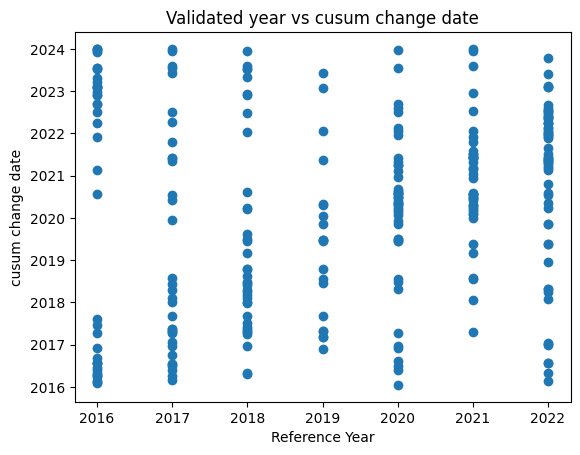

In [59]:
# Plotting validated data vs cusum change date
plt.scatter(gdf['Ref_Year'], gdf['cusum_change_date'])
plt.xlabel('Reference Year')
plt.ylabel('cusum change date')
plt.title('Validated year vs cusum change date')
plt.show()

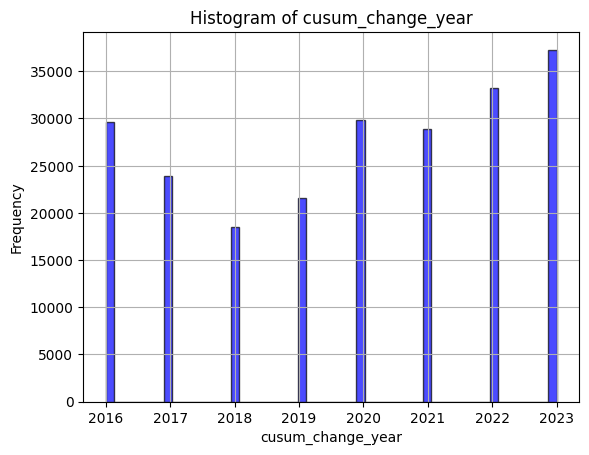

In [60]:
# plot histogram of cusum change
plt.hist(gdf['cusum_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of cusum_change_year')
plt.xlabel('cusum_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

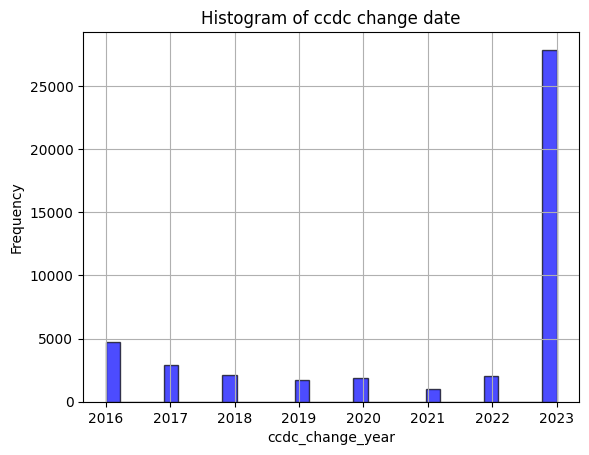

In [61]:
# plot histogram of ccfc change
gdf_ccdc = gdf[gdf['ccdc_change_year']>0]
plt.hist(gdf_ccdc['ccdc_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of ccdc change date')
plt.xlabel('ccdc_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

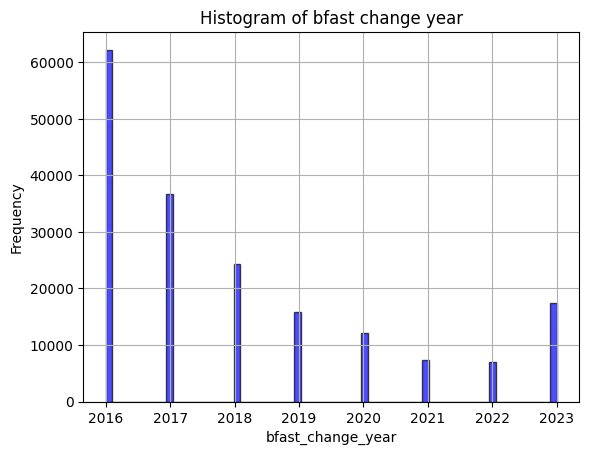

In [62]:
# plot histogram of cusum change
gdf_bfast = gdf[gdf['bfast_change_year']>0]
plt.hist(gdf_bfast['bfast_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of bfast change year')
plt.xlabel('bfast_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### assign change year classes based on classification and cusum dates

In [71]:
#use stratum counts to calculate stats from CEO  points
pd.pivot_table(gdf,values='point_id',index=['Ref_Change_Year_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg,1,2,3,Total
Ref_Change_Year_1522,,,,
Def2016,NaN,2,21,23
Def2017,NaN,3,11,14
Def2018,NaN,NaN,8,8
Def2019,NaN,NaN,2,2
Def2020,NaN,1,6,7
Def2021,NaN,1,6,7
Def2022,NaN,4,9,13
Deg2016,NaN,3,15,18
Deg2017,NaN,1,19,20


#### plot data

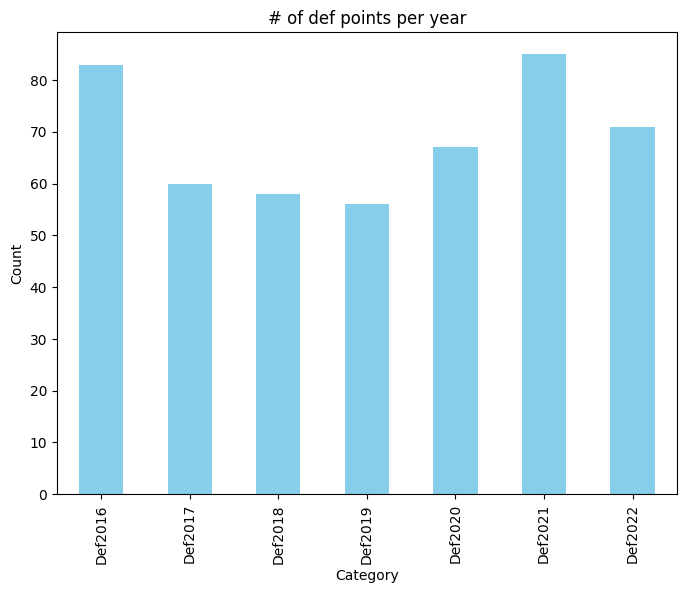

In [72]:
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_CEO_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_CEO_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of def points per year')

# Show the plot
plt.show()

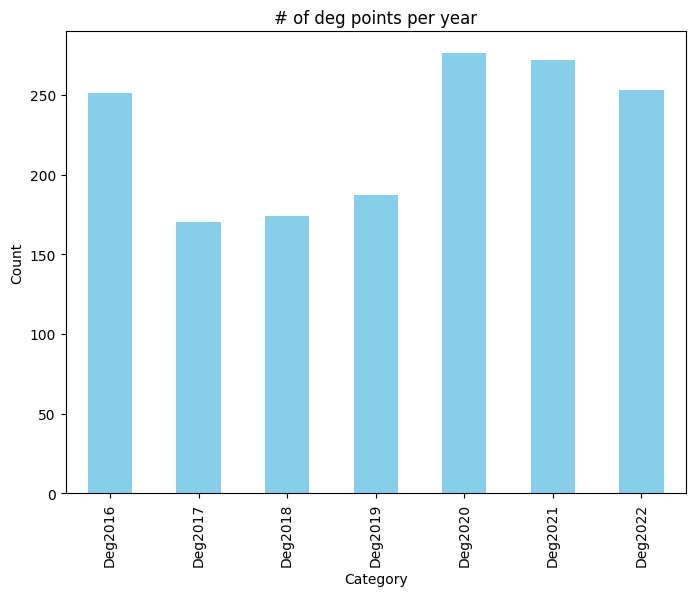

In [73]:
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_CEO_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_CEO_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of deg points per year')

# Show the plot
plt.show()

In [ ]:
gdf.to_csv(out_file,index=True)